# Computational Neuroscience

PSYC B265, Fall 2025

Today, we will classify stimuli from brain activity. Submitting today's lab is **optional**.

## Setup Jupyter notebook

In [4]:
!pip install nilearn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

### Download Data

In [2]:
from nilearn import datasets

# Download Haxby 2001 data
haxby_dataset = datasets.fetch_haxby(fetch_stimuli=True)

[fetch_haxby] Dataset found in /home/jupyter-ssemaan/nilearn_data/haxby2001

### Plot Stimuli

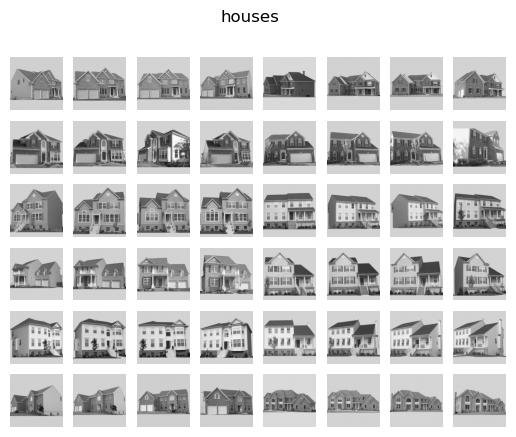

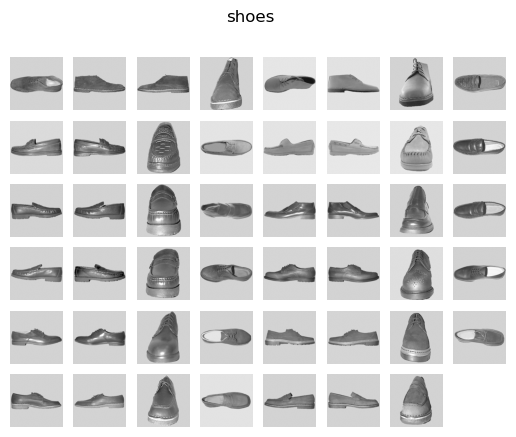

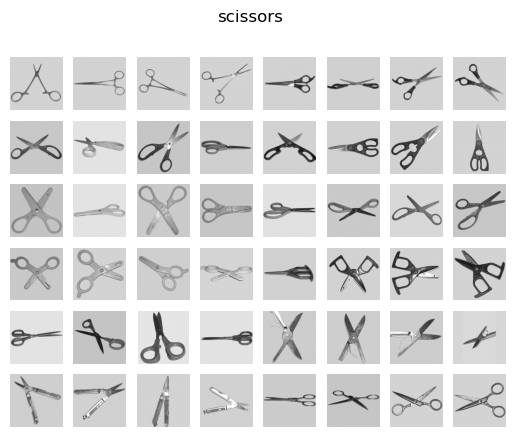

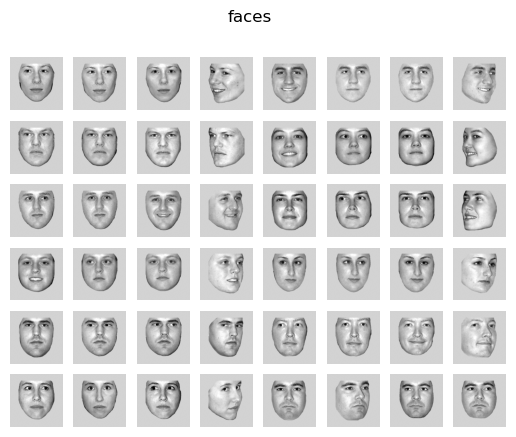

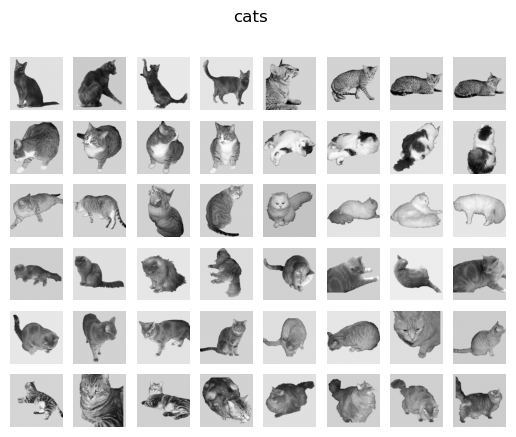

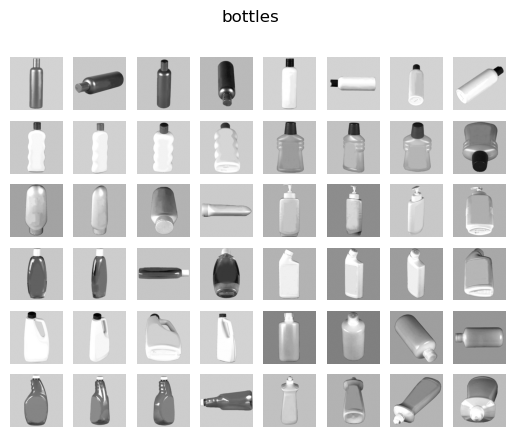

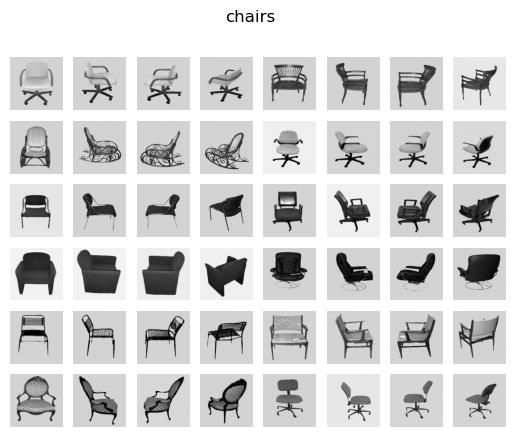

In [3]:
from nilearn.plotting import show

stimulus_information = haxby_dataset.stimuli

for stim_type in stimulus_information:
    # skip control images, there are too many
    if stim_type != "controls":
        file_names = stimulus_information[stim_type]

        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap="gray")

        for ax in axes.ravel():
            ax.axis("off")

show()

### functional MRI (fMRI) functional scans

In [4]:
# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

session

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


In [5]:
# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Create a boolean array indexing TRs containing a stimulus (non-rest)
task_trs = stimuli != 'rest'

# Get list of unique stimulus categories (excluding rest)
categories = [c for c in np.unique(stimuli) if c != 'rest']
print(categories)

['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix', 'shoe']


In [6]:
# Make sure we have the same number of TRs for data and labels
from nilearn.image import index_img

func_file = haxby_dataset.func[0]

func_task = index_img(func_file, task_trs)

stimuli_task = stimuli[task_trs]
runs_task = runs[task_trs]

assert len(stimuli_task) == len(runs_task) == func_task.shape[-1]

### Ventral Temporal Lobe Mask

In [7]:
# Get the VT mask file and create masker
from nilearn.maskers import NiftiMasker

mask = haxby_dataset['mask_vt'][0]
masker = NiftiMasker(mask_img=mask, standardize=True)

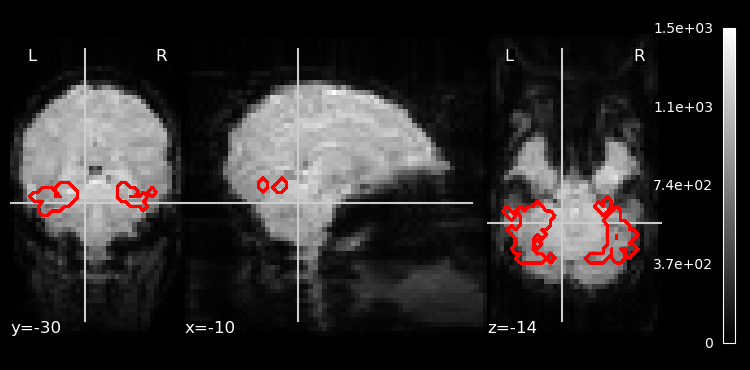

In [8]:
# Compute the mean EPI: we do the mean along the axis 3, which is time
from nilearn.image.image import mean_img
from nilearn.plotting import plot_epi

mean_haxby = mean_img(func_file, copy_header=True)

display = plot_epi(mean_haxby, cut_coords = [-10, -30, -14])
display.add_contours(
    mask,
    antialiased=False,
    levels=[0],
    colors=["red"]
)

### Extract data from Ventral Temporal lobe (VT)

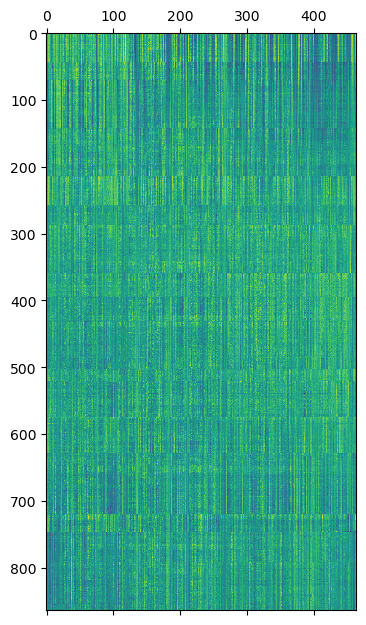

In [9]:
data = masker.fit_transform(func_task)

plt.matshow(data)

In [10]:
data.shape

(864, 464)

#### TODO:

How many voxels are included in the data? If you plot the activation on a cartesian plane, how many dimensions do you need?

> There are 464 voxels across 864 trials. We would need 464 dimensions to plot the activation on a cartesian plane.

#### TODO:

How many trials are included in the data? If you plot the activation on a cartesian plane, how many dots do you have?

> There are 864 trials included in the data, and we would need 864 dots to plot the trials on a cartesian plane.

### Train Classifier

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

cv = LeaveOneGroupOut()
classifier = LinearSVC()

# fit model to get predicted labels
y_pred = cross_val_predict(classifier,
                           data,
                           stimuli_task,
                           cv=cv,
                           groups=runs_task)

### Plot Confusion Matrix

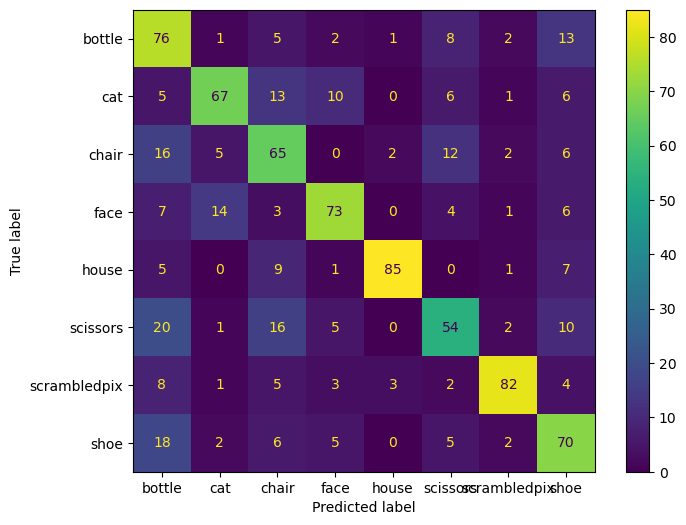

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix from true and predicted labels
cm = confusion_matrix(stimuli_task, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=categories).plot(ax=ax);

#### TODO:

How well did your classifier do? For example, are all faces correctly classified as faces? If not, what were they confused as?

> The classifier did relatively well, correctly classifying objects more times than not (66%). Relative to chance (1/8 = 16%), it is performing relatively well. For example, most faces are accurately classified as faces (73) but about 14 faces are incorrectly classified as cats, but non were classified as a house. We predicted that objects can be internally classified into larger categories (houses, creatures, household objects,e tc.), and the classifier was more likely to misclassify objects in the same category (e.g., cats and humans are both creatures).

In [ ]:
from sklearn.model_selection import cross_val_score

# Run classification
scores = cross_val_score(classifier,
                         data,
                         stimuli_task,
                         cv=cv,
                         groups=runs_task,
                         scoring="accuracy"
                         )

print(f"Overall mean classification accuracy: {np.mean(scores):.3f}")